# Spectral Slope Analysis

##### Jorge Yanar, June 2015

This notebook covers our pipeline so far for the spectral slope analysis. It proceeds as follows:

1. Import the EEG of all subjects
2. For each subject, compute the spectral slope of each channel and compute the mean slope
3. Add all slopes to our features matrix
4. Separate pandas data frame into mci and super-ager cohorts
5. Apply LASSO to slope features in order to determine which channels are strong predictors of 

Properties of the EEG data:
- Each is a 20-second recording of eyes-closed resting state EEG.
- Sampling rate of 512 Hz recorded on Biosemi 64-channel system.
- Eye-monitoring and both mastoid reference electrodes have been removed, as well as channels that fall further down the head than those found in the standard intl 10-20 montage, leaving us with 53 channels.
- EEG was re-referenced offline to the common average.
- Bandpass filter applied from 0.5 - 45 Hz.

In [1]:
%matplotlib inline
import os
import glob
import csv as csv
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import signal
from scipy import io
from sklearn import metrics, cross_validation, linear_model
from sklearn.grid_search import GridSearchCV

## Compute mean and channel spectral slopes for all subjects. 

In [2]:
subj = {} # Dictionary that holds subject data
matfiles = []
for root, dirs, files in os.walk('../data/extClfiltCAR-mat/'):
    matfiles += glob.glob(os.path.join(root, '*.mat'))

# Remove subjects for which we are missing behavioral measures
matfiles.remove('../data/extClfiltCAR-mat/120127133.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127134.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127140.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127154.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127160.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127167.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127132.mat')
matfiles.remove('../data/extClfiltCAR-mat/120127159.mat')

# Import all subjects
for i in range(len(matfiles)):
    datafile = sp.io.loadmat(matfiles[i])
    subj[i] = {}
    subj[i]['name']  = str(np.squeeze(datafile['name']))[6:]
    subj[i]['srate'] = int(np.squeeze(datafile['srate']))
    subj[i]['data']  = np.squeeze(datafile['data'])    

# Function for robustly fitting line to PSD. Returns slope.
# Note that we fit to the PSD in semi-log space.
# Also, fitting is only done from 0 - 24 Hz, as in Voytek et al. 2015 
def compute_slope(f, psd):
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0][0] * (10**2), fit_line

# For all subjects, compute the slope of each channel and find the mean slope
srate = 512
for i in subj:
    for ch in range(len(subj[i]['data'])):

        subj[i][ch] = {}
        
        f, psd = sp.signal.welch(subj[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subj[i][ch]['f'] = f
        subj[i][ch]['psd'] = psd
        
        # Remove alpha peak from the power spectrum:        
        subj[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subj[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subj[i][ch]['psd_sans_alpha'] = subj[i][ch]['psd_sans_alpha'].reshape((len(subj[i][ch]['psd_sans_alpha']), 1))
        subj[i][ch]['f_sans_alpha']   = subj[i][ch]['f_sans_alpha'].reshape((len(subj[i][ch]['f_sans_alpha']), 1))
        
        subj[i][ch]['slope'], subj[i][ch]['fit_line'] = compute_slope(subj[i][ch]['f_sans_alpha'], 
                                                                      subj[i][ch]['psd_sans_alpha']) 
    slopes = []
    for ch in range(len(subj[i]['data'])):
        slopes.append(subj[i][ch]['slope'])
    subj[i]['slope'] = np.mean(slopes)

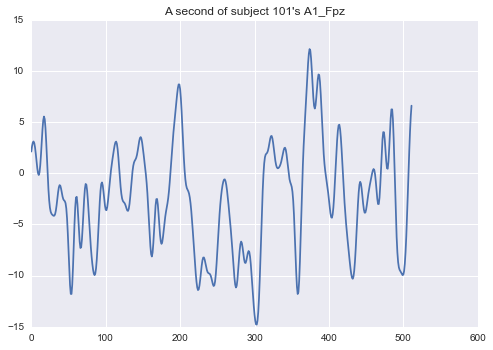

In [3]:
plt.title("A second of subject 101's A1_Fpz")
plt.plot(subj[0]['data'][0][512:1024])

Slope of fit line:  -0.0633620826472


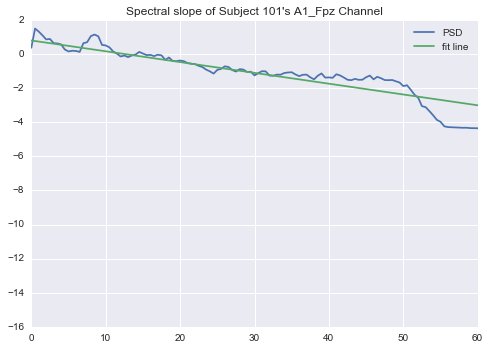

In [4]:
plt.title("Spectral slope of Subject 101's A1_Fpz Channel")
plt.plot(subj[0][0]['f'], np.log10(subj[0][0]['psd']), label='PSD')
plt.plot(subj[0][0]['f_sans_alpha'], subj[0][0]['fit_line'], label='fit line')
plt.legend(); plt.xlim([0, 60])
print("Slope of fit line: ", subj[0][0]['slope'] * (10**-2))

## Construct table for psd slopes (per-channel & mean slope)

We'll just read in the behavioral dataset and tack these on to the end. 

In [5]:
df = pd.read_csv('../data/madb_intclasses_use.csv', header=0)
df.head()

,Subject,Class,RAVLT_DEL,Age,Education,Sex_numberic,Animals,BNT_30,LM_1,LM_2,...,C3_BetaPower_fixed,C3_GammaPower_fixed,O1_DeltaPower_fixed,O1_ThetaPower_fixed,O1_AlphaPower_fixed,O1_Alpha1Power_fixed,O1_Alpha2Power_fixed,O1_Alpha3Power_fixed,O1_BetaPower_fixed,O1_GammaPower_fixed
0,101,2,3,80.84873,15,2,18,27,10,9,...,0.36673,0.020071,4.1044,4.88080,3.66930,3.66930,2.11570,0.97352,0.47525,0.106810
1,102,1,8,71.89870,16,1,22,30,15,14,...,0.36673,0.020071,4.1044,4.88080,3.66930,3.66930,2.11570,0.97352,0.47525,0.106810
2,103,1,11,69.43463,14,2,29,29,7,5,...,0.11818,0.029272,1.1242,0.53832,0.77607,0.77607,1.09520,0.62154,0.43603,0.371570
3,104,2,8,83.61396,14,2,22,27,16,15,...,0.58826,0.052404,3.5768,6.75820,23.66680,23.66680,36.56120,6.37160,1.39780,0.091309
4,105,2,7,80.69541,18,2,17,28,20,15,...,0.21081,0.069191,4.7605,1.30960,0.53454,0.53454,0.60461,0.45338,0.20894,0.047831


First we add each subject's average spectral slope to the table:

In [6]:
df['avg_psd_slope'] = [subj[i]['slope'] for i in subj]

Then the slope for each electrode. There are a total of 53 electrodes:

In [7]:
channels = ["A1_Fpz","A2_Fp1","A3_Fp3","A4_aF1","A5_aFz","A6_F1","A7 F1","A8 F1","A10_Fp5","A11 Fp5","A12 Fp5","A13 Fp5","A14_fCz","A15_Cz","A16 Cz","A17 Cz","A18 Cz","A21 LM","A22 LM","A23 LM","A24 LM","A25 LM","A26 LM","A27 LM","A29 LM","A30 LM","A31 LM","B1_Fp2","B2 Fp2","B3_aF2","B4_Fp4","B5 Fp4","B6 Fp4","B8_Fp6 G","B9 Fp6 G","B10 p6 G","B11 p6 G","B12 p6 G","B13 p6 G","B14 p6 G","B17 RM G","B18 RM G","B19 RM G","B20 RM G","B21_cPz","B22 cPz","B23 cPz","B24 cPz","B26 cPz","B27 cPz","B28_Pz","B29 Pz","B30 Pz"]

for ch in range(len(channels)):
    df[channels[ch]] = [subj[i][ch]['slope'] for i in subj]

Here are the features that we just added to the matrix:

In [8]:
df.loc[:, 'avg_psd_slope':].head()

,avg_psd_slope,A1_Fpz,A2_Fp1,A3_Fp3,A4_aF1,A5_aFz,A6_F1,A7 F1,A8 F1,A10_Fp5,...,B20 RM G,B21_cPz,B22 cPz,B23 cPz,B24 cPz,B26 cPz,B27 cPz,B28_Pz,B29 Pz,B30 Pz
0,-5.675593,-6.336208,-6.294332,-5.004732,-6.249184,-6.100178,-6.217711,-5.362356,-4.969659,-6.890068,...,-5.790248,-6.402308,-6.028250,-5.369111,-5.420802,-4.740119,-5.950079,-6.933514,-5.917265,-3.949545
1,-5.730035,-6.336208,-6.151471,-6.082252,-6.108779,-6.425005,-5.622105,-5.119527,-5.370460,-6.775490,...,-5.790248,-6.405756,-5.899588,-5.387336,-5.452224,-4.740119,-5.950079,-6.933514,-5.917265,-4.285510
2,-2.525743,-2.400202,-2.713485,-2.438469,-2.002632,-2.144965,-3.324616,-0.393069,-1.134866,-3.089200,...,-4.636181,-3.727705,-3.428549,-2.097598,-1.476231,0.039533,-2.358701,-3.011193,-2.148325,-1.883012
3,-5.169673,-4.000635,-4.152000,-4.099329,-3.422490,-4.238487,-0.544588,-3.883820,-2.803952,-4.231977,...,-5.134480,-4.169590,-4.363248,-4.292818,-4.715742,-5.035722,-4.729700,-4.973629,-4.516221,-5.169376
4,-4.822324,-4.166268,-4.483462,-4.171954,-4.299830,-4.934144,-4.478223,-5.864580,-4.733503,-4.981386,...,-5.993618,-4.508119,-5.226759,-6.093907,-5.126809,-5.480830,-6.794672,-5.055936,-5.431623,-5.945348


#### Separate out the SuperAger and MCI cohorts... (i.e., SAs and SA-Controls, MCIs and MCI-Controls)

In [9]:
mci_cohort   = df[df['Class'].isin([0, 1])]      # Contains both mcis and their controls
sa_cohort    = df[df['Class'].isin([2, 3])]      # Contains both SuperAgers and their controls
older_adults = df[df['Class'].isin([0, 1, 2])]   # Contains mcis, mci-controls, sa-controls. Excludes super-agers.
controls     = df[df['Class'].isin([0, 2])]      # Contains only controls
sa           = df[df['Class'].isin([2])]
mci          = df[df['Class'].isin([0])]

## Construct spatial topographic of correlation with age

Want to see which electrodes are predictive of RAVLT Delay (which is a long term memory measure) and aging.

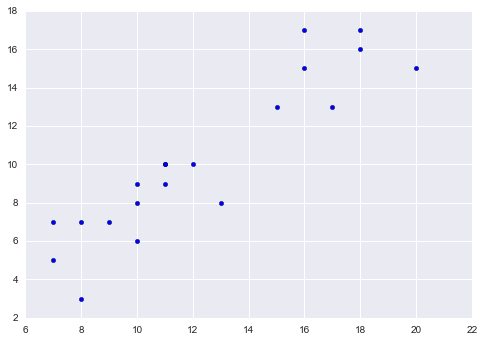

In [10]:
plt.scatter(controls['LM_1'], controls['LM_2'])

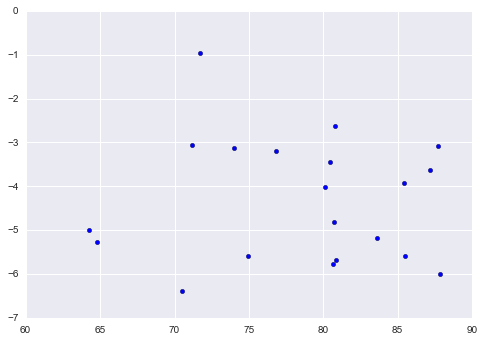

In [11]:
plt.scatter(controls['Age'], controls['avg_psd_slope'])

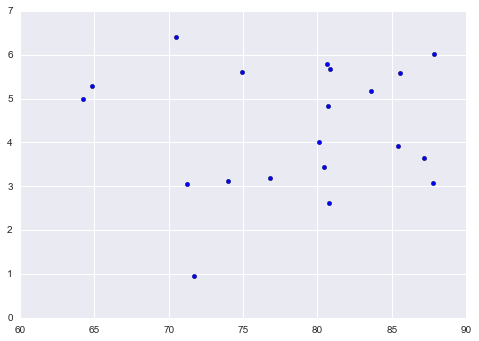

In [13]:
plt.scatter(controls['Age'], np.abs(controls['avg_psd_slope']))

In [16]:
np.corrcoef(controls['Age'], controls['avg_psd_slope'])

array([[ 1.        , -0.02966336],
       [-0.02966336,  1.        ]])

In [17]:
# B28, A29, B26
# Frontal Midline: A1, A5, A14, perhaps avg of: B4, A6, then use that as single entry and avg with first set (A1,A5..)
# Extrastriate:    LHS: A29, A30, A31; RHS: B23, B24, B26
# B21, B28, B29, A25, B22
# alt: Ran LASSO on age
# 
# - For LASSO on younger adults, we could run LASSO on all of them too.

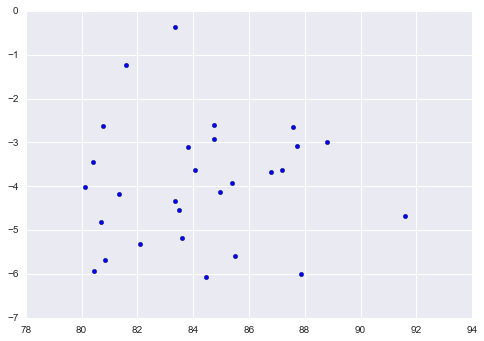

In [18]:
plt.scatter(sa_cohort['Age'], sa_cohort['avg_psd_slope'])

In [19]:
np.mean(sa_cohort['avg_psd_slope'])

-3.938901951612647

In [20]:
np.mean(mci_cohort['avg_psd_slope'])

-3.891752694550118

In [23]:
np.mean(controls.loc['Age'])

KeyError: 'the label [Age] is not in the [index]'